# Method: RNN
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
train.data = train.data[:13500]
train.time = train.time[:13500]

In [6]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (13500, 40)
Test size: (90000, 40)


**Create test set**

In [7]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [8]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [9]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. RNN Implementation

In [10]:
def RNN(h_dim, data_dim, alpha = 1, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """

    def init_fun(rng):
        """
        This function initialize the weights of the RNN

        args:
        ====
         rng: jax RNG

        outputs:
        ======
         params: a tuple of parameters
        """

        k1, k2, k3, k4, k5 = jax.random.split(rng, num = 5)
        W_in   = W_init(k1, (h_dim, data_dim))  # data to internal-state
        W_out  = W_init(k2, (data_dim, h_dim))  # internal-state to output 
        W_h    = W_init(k3, (h_dim, h_dim))     # internal-state to internal-state
        h_bias = b_init(k4, (h_dim, ))
        W_bias = b_init(k5, (data_dim, ))

        params = (W_in, W_out, W_h, h_bias, W_bias)
        return params

    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state

        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)

        outputs:
        =======
         h_last: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        # extract parameters
        W_in, W_out, W_h, h_bias, W_bias = params

        # initial hidden state is set to zero
        h_zero = jnp.zeros((h_dim, ))

        # forward pass
        # RNN: internal function to process data
        def process_internal(hidden, x):
            h_new = (1-alpha)*hidden + alpha * jnp.tanh( W_h@hidden + W_in@x + h_bias)
            #out   = W_out@jnp.concatenate([h_new, jnp.tanh(x)])
            out   = x + W_out @ h_new + W_bias
            return h_new, out
        h_final, pred_traj = jax.lax.scan(process_internal, h_zero, time_series)

        return h_final, pred_traj[-1]

    def forecast(params, h_internal, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.

        args:
        ====
         params: tuple of parameters
         h_internal:
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction

        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        # extract parameters
        W_in, W_out, W_h, h_bias, W_bias = params

        # forward pass
        # RNN: internal function to process data
        def forecast_internal(pair_h_x, _ ):
            hidden, x = pair_h_x
            h_new = (1-alpha) * hidden + alpha * jnp.tanh( W_h @ hidden + W_in @ x + h_bias)
            out   = x + W_out @ h_new + W_bias
            return (h_new, out), out 
        _, pred_traj = jax.lax.scan(forecast_internal, (h_internal, x_input), None, length=horizon)

        # return the trajectory of predictions
        return pred_traj

    return init_fun, process, forecast

In [32]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 2.):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = data_test[t_past_batch_val]
        y_val = data_test[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 20 == 0:
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize RNN
    init_fun, process, forecast = RNN(nn_size, data_dim)       # RNN Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [14]:
def get_test_pred(data_test, params, rnn_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = rnn_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [15]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-2, 1e-3, 1e-4] # Learning rate schedule
epoch_list = [200, 400, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [16]:
nn_size = 100

In [17]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 20: Time taken = 0.24 | Train loss = 0.0451043 | Val loss =  436.4398499
Epoch 40: Time taken = 0.23 | Train loss = 0.0317344 | Val loss =  624.9522095
Epoch 60: Time taken = 0.24 | Train loss = 0.0238882 | Val loss =  612.0596313
Epoch 80: Time taken = 0.22 | Train loss = 0.0194009 | Val loss =  676.4217529
Epoch 100: Time taken = 0.23 | Train loss = 0.0163666 | Val loss =  694.2874146
Epoch 120: Time taken = 0.22 | Train loss = 0.0146715 | Val loss =  621.1133423
Epoch 140: Time taken = 0.23 | Train loss = 0.0135877 | Val loss =  566.0310059
Epoch 160: Time taken = 0.24 | Train loss = 0.0127989 | Val loss =  544.4335938
Epoch 180: Time taken = 0.26 | Train loss = 0.0124224 | Val loss =  451.2669678
Epoch 200: Time taken = 0.22 | Train loss = 0.0116967 | Val loss =  424.4960022
Best Validation MSE: 4.5915070
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.22 | Train loss = 0.0346974 | Val loss =  258.7118530
Epoch 40: Time taken = 0.22 | Train loss = 0.0

In [18]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.38


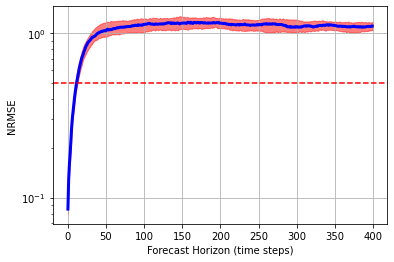

It takes around t = 0.12 for mean error to exceed 0.5


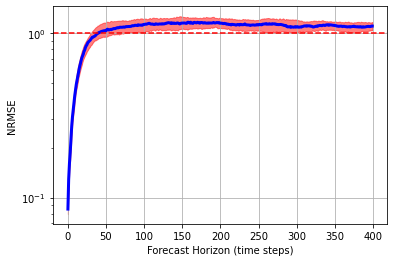

It takes around t = 0.41 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.741
Median NRMSE at t = 0.5: 1.033
Median NRMSE at t = 1: 1.128
Median NRMSE at t = 2: 1.149
Median NRMSE at t = 3: 1.090


In [19]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [20]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [21]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.21 | Train loss = 0.0214970 | Val loss =  3021.1018066
Epoch 40: Time taken = 0.22 | Train loss = 0.0097897 | Val loss =  3315.7053223
Epoch 60: Time taken = 0.21 | Train loss = 0.0061523 | Val loss =  2433.3364258
Epoch 80: Time taken = 0.21 | Train loss = 0.0043218 | Val loss =  1694.1728516
Epoch 100: Time taken = 0.21 | Train loss = 0.0034257 | Val loss =  1299.8424072
Epoch 120: Time taken = 0.21 | Train loss = 0.0027644 | Val loss =  948.3276367
Epoch 140: Time taken = 0.22 | Train loss = 0.0024199 | Val loss =  707.9981689
Epoch 160: Time taken = 0.22 | Train loss = 0.0022166 | Val loss =  485.5346680
Epoch 180: Time taken = 0.22 | Train loss = 0.0018126 | Val loss =  372.7702026
Epoch 200: Time taken = 0.21 | Train loss = 0.0016633 | Val loss =  296.4543762
Epoch 220: Time taken = 0.21 | Train loss = 0.0015548 | Val loss =  188.9026642
Epoch 240: Time taken = 0.21 | Train loss = 0.0014050 | Val loss =  168.2358093
Epoch 260: Time 

In [22]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.36


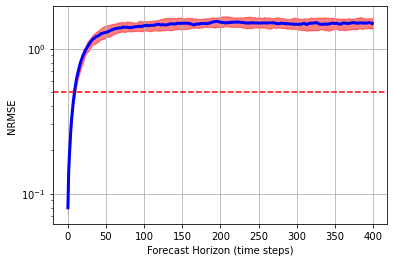

It takes around t = 0.09 for mean error to exceed 0.5


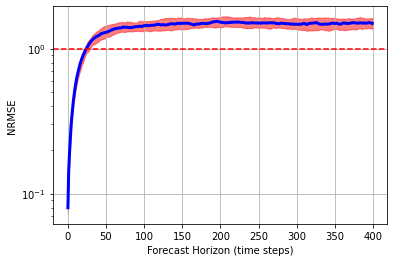

It takes around t = 0.25 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.901
Median NRMSE at t = 0.5: 1.295
Median NRMSE at t = 1: 1.438
Median NRMSE at t = 2: 1.526
Median NRMSE at t = 3: 1.475


In [23]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [24]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [25]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.40 | Train loss = 0.0081444 | Val loss =  19.2981377
Epoch 40: Time taken = 0.40 | Train loss = 0.0047834 | Val loss =  3.8671925
Epoch 60: Time taken = 0.40 | Train loss = 0.0039769 | Val loss =  2.3834717
Epoch 80: Time taken = 0.40 | Train loss = 0.0030050 | Val loss =  2.1156735
Epoch 100: Time taken = 0.40 | Train loss = 0.0027952 | Val loss =  1.9595283
Epoch 120: Time taken = 0.40 | Train loss = 0.0019156 | Val loss =  1.9114633
Epoch 140: Time taken = 0.40 | Train loss = 0.0017102 | Val loss =  1.8346127
Epoch 160: Time taken = 0.40 | Train loss = 0.0018565 | Val loss =  1.8233969
Epoch 180: Time taken = 0.40 | Train loss = 0.0015112 | Val loss =  1.7542782
Epoch 200: Time taken = 0.40 | Train loss = 0.0013916 | Val loss =  1.7302910
Epoch 220: Time taken = 0.40 | Train loss = 0.0020186 | Val loss =  1.7232083
Epoch 240: Time taken = 0.40 | Train loss = 0.0015528 | Val loss =  1.7200490
Epoch 260: Time taken = 0.40 | Train loss = 

In [26]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 0.49


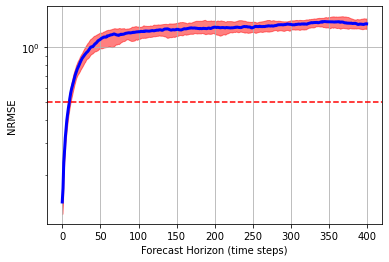

It takes around t = 0.10 for mean error to exceed 0.5


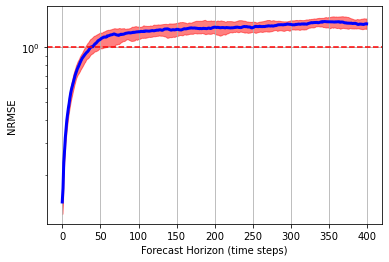

It takes around t = 0.38 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.767
Median NRMSE at t = 0.5: 1.107
Median NRMSE at t = 1: 1.218
Median NRMSE at t = 2: 1.290
Median NRMSE at t = 3: 1.335


In [27]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [28]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [29]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.68 | Train loss = 0.0055006 | Val loss =  2.2310653
Epoch 40: Time taken = 0.69 | Train loss = 0.0041740 | Val loss =  1.9621832
Epoch 60: Time taken = 0.68 | Train loss = 0.0042018 | Val loss =  1.7879168
Epoch 80: Time taken = 0.69 | Train loss = 0.0041641 | Val loss =  1.7449303
Epoch 100: Time taken = 0.69 | Train loss = 0.0036724 | Val loss =  1.7311201
Epoch 120: Time taken = 0.69 | Train loss = 0.0026041 | Val loss =  1.7055953
Epoch 140: Time taken = 0.70 | Train loss = 0.0036494 | Val loss =  1.6644112
Epoch 160: Time taken = 0.70 | Train loss = 0.0023199 | Val loss =  1.6441773
Epoch 180: Time taken = 0.69 | Train loss = 0.0021521 | Val loss =  1.6089436
Epoch 200: Time taken = 0.69 | Train loss = 0.0024500 | Val loss =  1.6246883
Epoch 220: Time taken = 0.68 | Train loss = 0.0021115 | Val loss =  1.6197002
Epoch 240: Time taken = 0.69 | Train loss = 0.0019958 | Val loss =  1.5733669
Epoch 260: Time taken = 0.68 | Train loss = 0

In [30]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 0.63


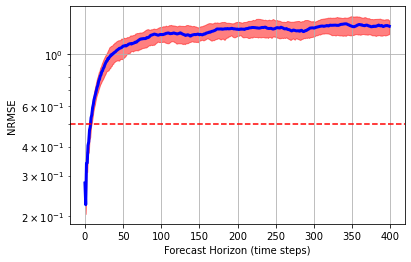

It takes around t = 0.08 for mean error to exceed 0.5


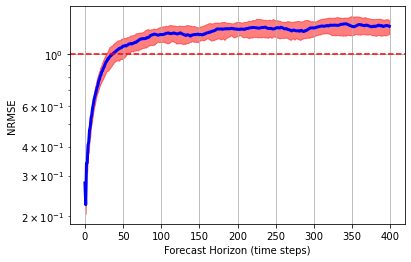

It takes around t = 0.36 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.805
Median NRMSE at t = 0.5: 1.085
Median NRMSE at t = 1: 1.215
Median NRMSE at t = 2: 1.285
Median NRMSE at t = 3: 1.298


In [31]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 1000
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [37]:
nn_size = 100
lr_list = [1e-2, 1e-3, 1e-4] # Learning rate schedule
epoch_list = [200, 400, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [38]:
L_forecast_train = 4; L_past = 1

In [39]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.13 | Train loss = 0.0170587 | Val loss =  612.6226807
Epoch 40: Time taken = 0.13 | Train loss = 0.0112626 | Val loss =  570.3002319
Epoch 60: Time taken = 0.13 | Train loss = 0.0083376 | Val loss =  559.3544312
Epoch 80: Time taken = 0.13 | Train loss = 0.0067244 | Val loss =  574.8331909
Epoch 100: Time taken = 0.13 | Train loss = 0.0057211 | Val loss =  637.9821167
Epoch 120: Time taken = 0.13 | Train loss = 0.0051569 | Val loss =  750.9848022
Epoch 140: Time taken = 0.13 | Train loss = 0.0047690 | Val loss =  811.5790405
Epoch 160: Time taken = 0.14 | Train loss = 0.0045023 | Val loss =  896.8915405
Epoch 180: Time taken = 0.14 | Train loss = 0.0043372 | Val loss =  967.0924072
Epoch 200: Time taken = 0.13 | Train loss = 0.0042222 | Val loss =  995.0422363
Best Validation MSE: 379.4601746
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.13 | Train loss = 0.0129121 | Val loss =  60.0379601
Epoch 40: Time taken = 0.13 | Train loss = 0.

In [40]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 0.24


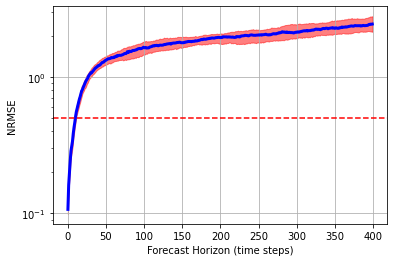

It takes around t = 0.10 for mean error to exceed 0.5


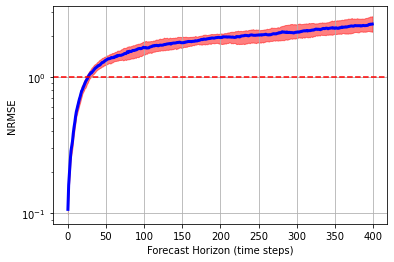

It takes around t = 0.27 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.836
Median NRMSE at t = 0.5: 1.322
Median NRMSE at t = 1: 1.631
Median NRMSE at t = 2: 1.932
Median NRMSE at t = 3: 2.115


In [41]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [42]:
L_forecast_train = 4; L_past = 4

In [43]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.17 | Train loss = 0.0144009 | Val loss =  1926.8386230
Epoch 40: Time taken = 0.17 | Train loss = 0.0105522 | Val loss =  2035.0430908
Epoch 60: Time taken = 0.18 | Train loss = 0.0087549 | Val loss =  2383.9294434
Epoch 80: Time taken = 0.18 | Train loss = 0.0077259 | Val loss =  2492.6071777
Epoch 100: Time taken = 0.18 | Train loss = 0.0071203 | Val loss =  2561.7111816
Epoch 120: Time taken = 0.18 | Train loss = 0.0066465 | Val loss =  2705.3200684
Epoch 140: Time taken = 0.18 | Train loss = 0.0064030 | Val loss =  2960.2216797
Epoch 160: Time taken = 0.20 | Train loss = 0.0060269 | Val loss =  2903.6992188
Epoch 180: Time taken = 0.18 | Train loss = 0.0058508 | Val loss =  3085.5825195
Epoch 200: Time taken = 0.18 | Train loss = 0.0056577 | Val loss =  2727.3354492
Best Validation MSE: 217.5608063
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.17 | Train loss = 0.0130288 | Val loss =  3240.6174316
Epoch 40: Time taken = 0.17 | Tra

In [44]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_2_mu_preds.pkl")

Testing complete. Time taken: 0.26


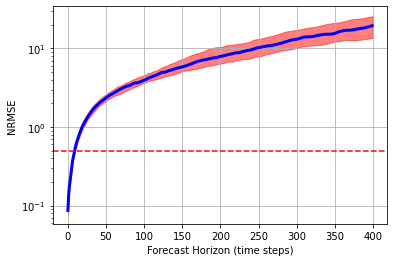

It takes around t = 0.09 for mean error to exceed 0.5


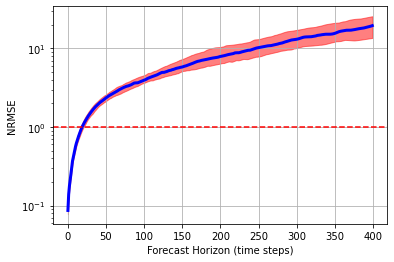

It takes around t = 0.19 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 1.068
Median NRMSE at t = 0.5: 2.351
Median NRMSE at t = 1: 3.946
Median NRMSE at t = 2: 7.893
Median NRMSE at t = 3: 13.074


In [45]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [46]:
L_forecast_train = 4; L_past = 8

In [47]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.21 | Train loss = 0.0143200 | Val loss =  2049.2243652
Epoch 40: Time taken = 0.23 | Train loss = 0.0111346 | Val loss =  2436.2656250
Epoch 60: Time taken = 0.23 | Train loss = 0.0098528 | Val loss =  2757.4953613
Epoch 80: Time taken = 0.22 | Train loss = 0.0090069 | Val loss =  2976.3591309
Epoch 100: Time taken = 0.23 | Train loss = 0.0085163 | Val loss =  3189.8413086
Epoch 120: Time taken = 0.23 | Train loss = 0.0081504 | Val loss =  3010.9172363
Epoch 140: Time taken = 0.23 | Train loss = 0.0078972 | Val loss =  2886.0534668
Epoch 160: Time taken = 0.24 | Train loss = 0.0077233 | Val loss =  2789.7587891
Epoch 180: Time taken = 0.24 | Train loss = 0.0075052 | Val loss =  2883.1586914
Epoch 200: Time taken = 0.23 | Train loss = 0.0074500 | Val loss =  2670.5126953
Best Validation MSE: 58.3773346
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.22 | Train loss = 0.0119851 | Val loss =  3140.1733398
Epoch 40: Time taken = 0.22 | Trai

In [48]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_3_mu_preds.pkl")

Testing complete. Time taken: 0.25


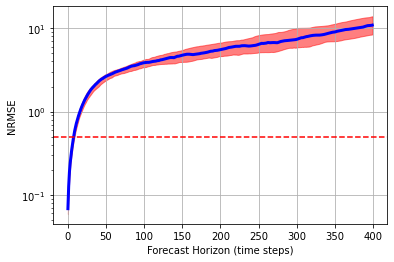

It takes around t = 0.08 for mean error to exceed 0.5


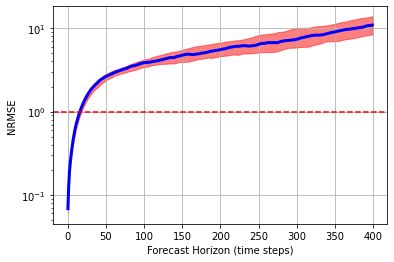

It takes around t = 0.16 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 1.255
Median NRMSE at t = 0.5: 2.654
Median NRMSE at t = 1: 3.854
Median NRMSE at t = 2: 5.539
Median NRMSE at t = 3: 7.365


In [49]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [50]:
L_forecast_train = 8; L_past = 1

In [51]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.19 | Train loss = 0.0481844 | Val loss =  472.6705933
Epoch 40: Time taken = 0.18 | Train loss = 0.0352344 | Val loss =  421.2564392
Epoch 60: Time taken = 0.18 | Train loss = 0.0289840 | Val loss =  251.0815735
Epoch 80: Time taken = 0.18 | Train loss = 0.0257838 | Val loss =  253.4273987
Epoch 100: Time taken = 0.18 | Train loss = 0.0239172 | Val loss =  196.2721405
Epoch 120: Time taken = 0.18 | Train loss = 0.0227521 | Val loss =  161.1410522
Epoch 140: Time taken = 0.18 | Train loss = 0.0219070 | Val loss =  182.4260712
Epoch 160: Time taken = 0.18 | Train loss = 0.0212200 | Val loss =  174.6344910
Epoch 180: Time taken = 0.17 | Train loss = 0.0208984 | Val loss =  156.2214355
Epoch 200: Time taken = 0.18 | Train loss = 0.0205649 | Val loss =  182.5842590
Best Validation MSE: 106.1699600
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.17 | Train loss = 0.0355731 | Val loss =  4.5965724
EARLY STOPPING. Epoch 32: Train loss = 0.03195

In [52]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 0.26


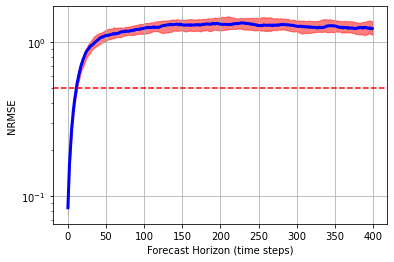

It takes around t = 0.12 for mean error to exceed 0.5


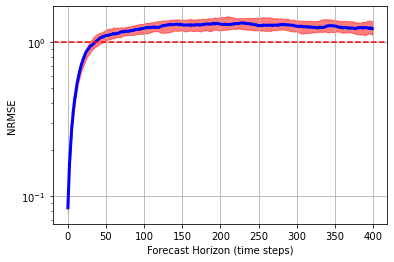

It takes around t = 0.36 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.776
Median NRMSE at t = 0.5: 1.104
Median NRMSE at t = 1: 1.232
Median NRMSE at t = 2: 1.308
Median NRMSE at t = 3: 1.271


In [53]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [54]:
L_forecast_train = 8; L_past = 4

In [55]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.22 | Train loss = 0.0451043 | Val loss =  436.4398499
Epoch 40: Time taken = 0.22 | Train loss = 0.0317344 | Val loss =  624.9522095
Epoch 60: Time taken = 0.22 | Train loss = 0.0238882 | Val loss =  612.0596313
Epoch 80: Time taken = 0.21 | Train loss = 0.0194009 | Val loss =  676.4217529
Epoch 100: Time taken = 0.22 | Train loss = 0.0163666 | Val loss =  694.2874146
Epoch 120: Time taken = 0.23 | Train loss = 0.0146715 | Val loss =  621.1133423
Epoch 140: Time taken = 0.23 | Train loss = 0.0135877 | Val loss =  566.0310059
Epoch 160: Time taken = 0.23 | Train loss = 0.0127989 | Val loss =  544.4335938
Epoch 180: Time taken = 0.24 | Train loss = 0.0124224 | Val loss =  451.2669678
Epoch 200: Time taken = 0.23 | Train loss = 0.0116967 | Val loss =  424.4960022
Best Validation MSE: 4.5915070
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.23 | Train loss = 0.0346974 | Val loss =  258.7118530
EARLY STOPPING. Epoch 31: Train loss = 0.03155

In [56]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_5_mu_preds.pkl")

Testing complete. Time taken: 0.28


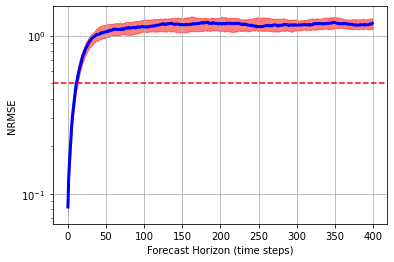

It takes around t = 0.12 for mean error to exceed 0.5


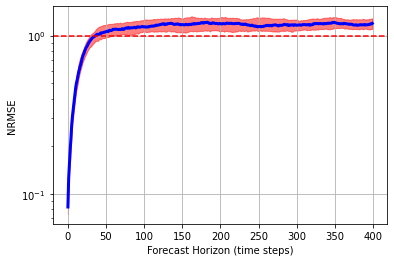

It takes around t = 0.36 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.755
Median NRMSE at t = 0.5: 1.060
Median NRMSE at t = 1: 1.135
Median NRMSE at t = 2: 1.191
Median NRMSE at t = 3: 1.164


In [57]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [58]:
L_forecast_train = 8; L_past = 8

In [59]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.27 | Train loss = 0.0429655 | Val loss =  416.9970703
Epoch 40: Time taken = 0.30 | Train loss = 0.0321792 | Val loss =  1041.0593262
Epoch 60: Time taken = 0.27 | Train loss = 0.0269569 | Val loss =  1265.2701416
Epoch 80: Time taken = 0.26 | Train loss = 0.0232960 | Val loss =  979.8026733
Epoch 100: Time taken = 0.25 | Train loss = 0.0209203 | Val loss =  758.8254395
Epoch 120: Time taken = 0.25 | Train loss = 0.0188038 | Val loss =  1070.6942139
Epoch 140: Time taken = 0.25 | Train loss = 0.0176046 | Val loss =  909.8497314
Epoch 160: Time taken = 0.26 | Train loss = 0.0165137 | Val loss =  820.9396362
Epoch 180: Time taken = 0.26 | Train loss = 0.0155830 | Val loss =  960.8205566
Epoch 200: Time taken = 0.26 | Train loss = 0.0148887 | Val loss =  846.1413574
Best Validation MSE: 2.0720353
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.25 | Train loss = 0.0356012 | Val loss =  267.8973389
Epoch 40: Time taken = 0.25 | Train loss = 

In [60]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_6_mu_preds.pkl")

Testing complete. Time taken: 0.25


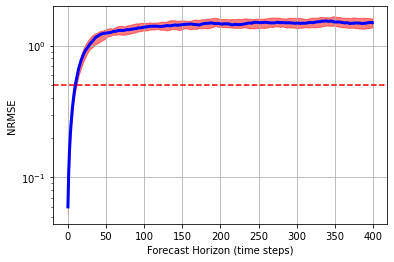

It takes around t = 0.10 for mean error to exceed 0.5


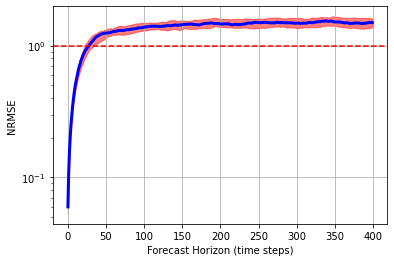

It takes around t = 0.28 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.849
Median NRMSE at t = 0.5: 1.245
Median NRMSE at t = 1: 1.379
Median NRMSE at t = 2: 1.462
Median NRMSE at t = 3: 1.481


In [61]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [62]:
L_forecast_train = 16; L_past = 1

In [63]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.26 | Train loss = 0.1473621 | Val loss =  1.5701866
Epoch 40: Time taken = 0.25 | Train loss = 0.1101872 | Val loss =  75.4961624
EARLY STOPPING. Epoch 42: Train loss = 0.1083594 | Val loss =  93.4624863
Best Validation MSE: 1.2232380
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.26 | Train loss = 0.1048516 | Val loss =  1.0990514
EARLY STOPPING. Epoch 39: Train loss = 0.0911929 | Val loss =  1.2787248
Best Validation MSE: 1.0356956
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.26 | Train loss = 0.0978206 | Val loss =  1.4009467
EARLY STOPPING. Epoch 32: Train loss = 0.0925671 | Val loss =  1.4670606
Best Validation MSE: 1.1462797

Total time: 30.29
Complete. Time taken: 30.30s


In [64]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_7_mu_preds.pkl")

Testing complete. Time taken: 0.23


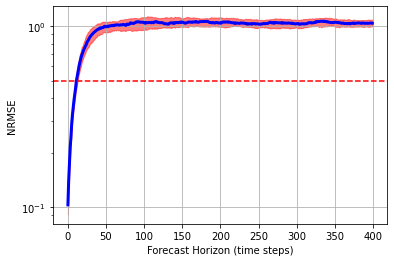

It takes around t = 0.12 for mean error to exceed 0.5


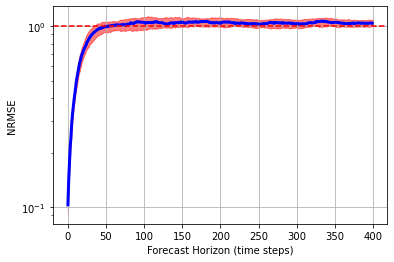

It takes around t = 0.52 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.727
Median NRMSE at t = 0.5: 0.997
Median NRMSE at t = 1: 1.048
Median NRMSE at t = 2: 1.045
Median NRMSE at t = 3: 1.033


In [65]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [66]:
L_forecast_train = 16; L_past = 4

In [67]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.30 | Train loss = 0.1501059 | Val loss =  1.2230204
EARLY STOPPING. Epoch 34: Train loss = 0.1228891 | Val loss =  36.6736031
Best Validation MSE: 1.0385536
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.30 | Train loss = 0.1232297 | Val loss =  1.1128592
EARLY STOPPING. Epoch 36: Train loss = 0.0994871 | Val loss =  1.2533377
Best Validation MSE: 0.9166160
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.33 | Train loss = 0.1078503 | Val loss =  1.3025562
EARLY STOPPING. Epoch 33: Train loss = 0.0967954 | Val loss =  1.3822792
Best Validation MSE: 0.9315377

Total time: 32.93
Complete. Time taken: 32.94s


In [68]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_8_mu_preds.pkl")

Testing complete. Time taken: 0.28


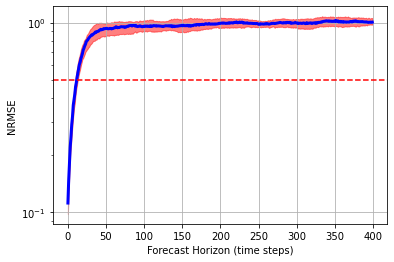

It takes around t = 0.12 for mean error to exceed 0.5


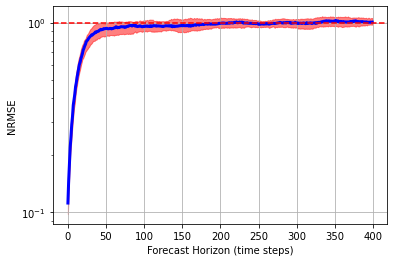

It takes around t = 2.18 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.716
Median NRMSE at t = 0.5: 0.932
Median NRMSE at t = 1: 0.954
Median NRMSE at t = 2: 0.991
Median NRMSE at t = 3: 0.995


In [69]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [70]:
L_forecast_train = 16; L_past = 8

In [71]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.38 | Train loss = 0.1438582 | Val loss =  2.7226889
EARLY STOPPING. Epoch 33: Train loss = 0.1213614 | Val loss =  28.1316357
Best Validation MSE: 1.2572966
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.35 | Train loss = 0.1068383 | Val loss =  3.7603724
EARLY STOPPING. Epoch 31: Train loss = 0.0928416 | Val loss =  22.4661961
Best Validation MSE: 1.0115117
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.34 | Train loss = 0.1424535 | Val loss =  0.9999387
EARLY STOPPING. Epoch 39: Train loss = 0.1353935 | Val loss =  1.1563995
Best Validation MSE: 0.9153962
IMPROVED VALIDATION MSE

Total time: 38.91
Complete. Time taken: 38.92s


In [72]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
# save_obj(mean_pred, "results/rnn", "3_2_9_mu_preds.pkl")

Testing complete. Time taken: 0.24


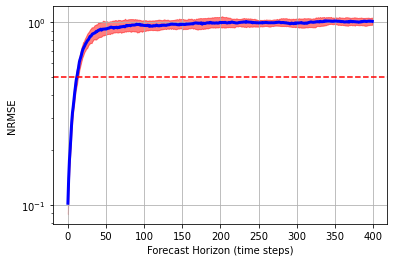

It takes around t = 0.12 for mean error to exceed 0.5


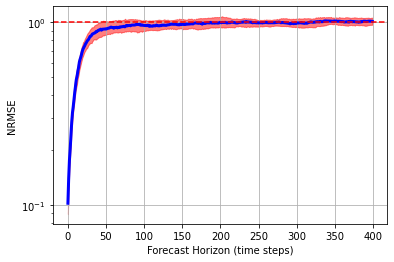

It takes around t = 1.87 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.717
Median NRMSE at t = 0.5: 0.919
Median NRMSE at t = 1: 0.963
Median NRMSE at t = 2: 1.001
Median NRMSE at t = 3: 0.992


In [73]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 500  
L_forecast_train = 4  
L_past = 4

In [74]:
nn_size = 100
L_forecast_train = 16
L_past = 4

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5, 1e-6] # Learning rate schedule
epoch_list = [400, 400, 400, 400]  # Number of epochs for each learning rate

In [75]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 50)

Backpropogation start

Epoch 20: Time taken = 0.33 | Train loss = 0.3751998 | Val loss =  132.1560059
Epoch 40: Time taken = 0.33 | Train loss = 0.2237199 | Val loss =  18.1021957
Epoch 60: Time taken = 0.34 | Train loss = 0.1614655 | Val loss =  6.9824681
Epoch 80: Time taken = 0.34 | Train loss = 0.1405159 | Val loss =  53.9869652
Epoch 100: Time taken = 0.30 | Train loss = 0.1281288 | Val loss =  394.5820618
EARLY STOPPING. Epoch 104: Train loss = 0.1258782 | Val loss =  487.8778687
Best Validation MSE: 1.1377145
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.30 | Train loss = 0.1358663 | Val loss =  114.8940887
Epoch 40: Time taken = 0.30 | Train loss = 0.1234357 | Val loss =  707.4730225
Epoch 60: Time taken = 0.30 | Train loss = 0.1144166 | Val loss =  1027.4023438
EARLY STOPPING. Epoch 60: Train loss = 0.1144166 | Val loss =  1027.4023438
Best Validation MSE: 1.2131374

Epoch 20: Time taken = 0.29 | Train loss = 0.1254389 | Val loss =  223.2137756
Epoch 40: Time taken = 0.29 

In [76]:
mean_pred = get_test_pred(X_test, params, rnn_fx)

Testing complete. Time taken: 0.31


In [77]:
save_obj(params, "results/rnn", "best_params.pkl")
save_obj(mean_pred, "results/rnn", "best_mu_preds.pkl")

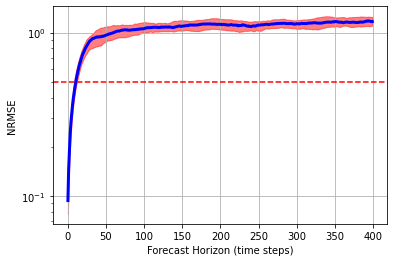

It takes around t = 0.11 for mean error to exceed 0.5


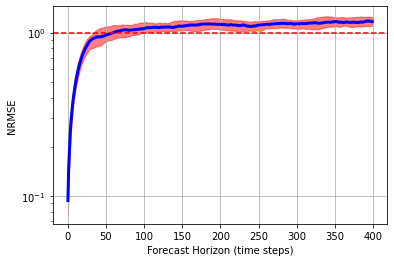

It takes around t = 0.60 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.747
Median NRMSE at t = 0.5: 0.966
Median NRMSE at t = 1: 1.058
Median NRMSE at t = 2: 1.124
Median NRMSE at t = 3: 1.134


In [78]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [13]:
# nn_size = 100
# _, process, forecast = RNN(nn_size, data_dim)       # RNN Network
# process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
# forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [14]:
# params = load_obj("results/rnn/best_params.pkl")

In [79]:
# mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))
save_obj(mean_pred, "results", "rnn_pred.pkl")

In [80]:
mean_pred = load_obj("results/rnn_pred.pkl")

In [81]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

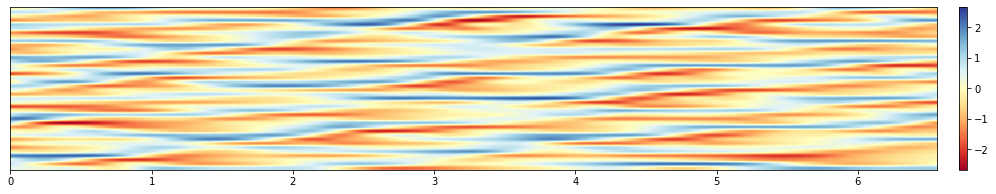

In [82]:
plt.figure(figsize = (20, 3))
plt.imshow(y_test[0].T, cmap = "RdYlBu", aspect = "auto", extent = [0, total_lyapunov_time_pred, 0, 40])
plt.tick_params(axis='both', which='both', left = False, labelleft = False,) 
plt.colorbar(pad = 0.02)
# plt.xlabel("Lyapunov Time")
# plt.title("Actual")
plt.savefig("lorenz_vsmall_actual.png", facecolor = "white", bbox_inches = "tight")
plt.show()

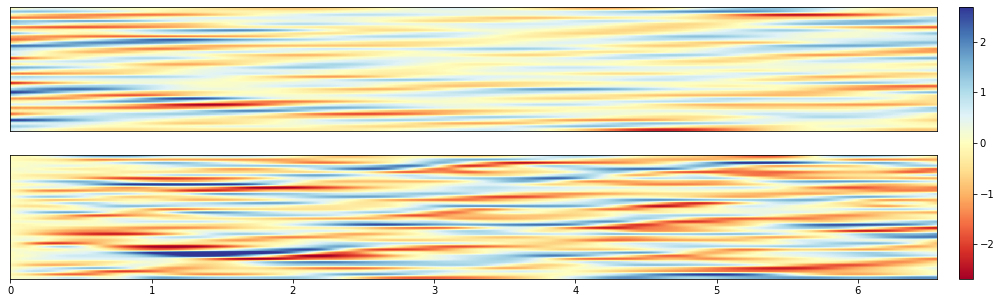

In [83]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_vsmall_rnn", pred_only = True)

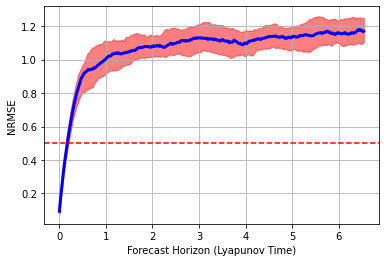

It takes around 0.18 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.897
Median NRMSE at 1.0 Lyapunov Time: 1.004
Median NRMSE at 2.0 Lyapunov Time: 1.081
Median NRMSE at 5.0 Lyapunov Time: 1.136


In [84]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "lorenz_vsmall_rnn_ph")
print()
res_single.get_loss()